In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D,Input,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.callbacks import ModelCheckpoint
import itertools 
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.simplefilter(action='ignore', category = FutureWarning)

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Number of GPUs Available',len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Number of GPUs Available 1


In [4]:
train_path = 'Test_Technique_Image/Neuroflux_disorder_splitted/train'
valid_path = 'Test_Technique_Image/Neuroflux_disorder_splitted/val'
test_path = 'Test_Technique_Image/Neuroflux_disorder_splitted/test'

In [5]:
trainAug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")

valAug = ImageDataGenerator(
    rescale=1 / 255.0)
testAug = ImageDataGenerator(
    rescale=1 / 255.0)

In [6]:
train_batches = trainAug.flow_from_directory(directory=train_path, class_mode="categorical",target_size=(256,256), color_mode="rgb", classes=['EO','IO','IPTE','LO','PTE'], shuffle=True,batch_size=32)
valid_batches = valAug.flow_from_directory(directory=valid_path,class_mode="categorical",target_size=(256,256), color_mode="rgb", classes=['EO','IO','IPTE','LO','PTE'], batch_size=32,shuffle=False)
test_batches = testAug.flow_from_directory(directory=test_path, class_mode="categorical",target_size=(256,256), color_mode="rgb", classes=['EO','IO','IPTE','LO','PTE'], batch_size=32 , shuffle=False)

Found 899 images belonging to 5 classes.
Found 256 images belonging to 5 classes.
Found 133 images belonging to 5 classes.


In [7]:
totalTrain = len(list(paths.list_images(train_path)))
print(totalTrain)
totalVal = len(list(paths.list_images(valid_path)))
print(totalVal)
totalTest = len(list(paths.list_images(test_path)))
print(totalTest)

899
256
133


In [8]:
trainLabels = train_batches.classes

In [9]:
trainLabels = to_categorical(trainLabels)

In [10]:
trainLabels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [11]:
classTotals = trainLabels.sum(axis=0)

In [12]:
classTotals

array([161.,  50., 119., 168., 401.], dtype=float32)

In [13]:
classWeight = dict()

In [14]:
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

In [15]:
classWeight

{0: 2.4906833, 1: 8.02, 2: 3.3697479, 3: 2.3869047, 4: 1.0}

In [16]:
BATCH_SIZE = 32
epochs = 60

In [17]:
imgs, labels = next(train_batches)

In [18]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

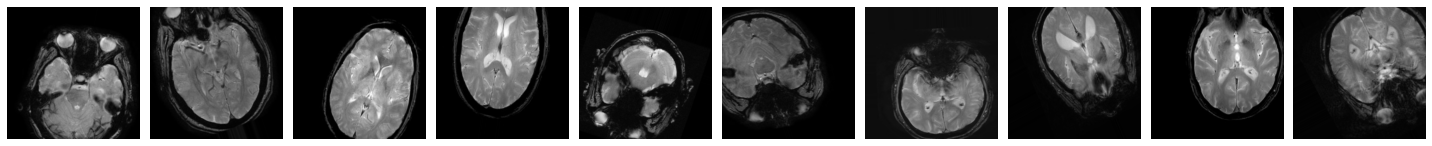

[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [19]:
plotImages(imgs)
print(labels)

In [20]:
model = Sequential ()

In [21]:
model.add(Conv2D(32, (3,3), padding="same",input_shape=(256, 256, 3)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(5))
model.add(Activation("softmax"))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0

In [25]:
filepath = "Model_2.h5"

In [26]:
checkpoint = ModelCheckpoint( filepath , monitor = 'val_acc', verbose =1, mode = 'max' )

In [27]:
callbacks_list = [checkpoint]

In [28]:
opt = Adam(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [29]:
print("[INFO] training ...")
H = model.fit(
	x=train_batches,
	steps_per_epoch=totalTrain // BATCH_SIZE,
	validation_data=valid_batches,
	validation_steps=totalVal // BATCH_SIZE,
    class_weight=classWeight,
	epochs=epochs,
    callbacks = callbacks_list)

[INFO] training head...
Epoch 1/60
28/28 [==============================] - ETA: 0s - loss: 5.8115 - accuracy: 0.1949
Epoch 00001: saving model to Model_2.h5
28/28 [==============================] - 13s 458ms/step - loss: 5.8115 - accuracy: 0.1949 - val_loss: 2.0255 - val_accuracy: 0.0547
Epoch 2/60
28/28 [==============================] - ETA: 0s - loss: 4.7699 - accuracy: 0.2065
Epoch 00002: saving model to Model_2.h5
28/28 [==============================] - 13s 464ms/step - loss: 4.7699 - accuracy: 0.2065 - val_loss: 2.5429 - val_accuracy: 0.1719
Epoch 3/60
28/28 [==============================] - ETA: 0s - loss: 4.8575 - accuracy: 0.1961
Epoch 00003: saving model to Model_2.h5
28/28 [==============================] - 13s 475ms/step - loss: 4.8575 - accuracy: 0.1961 - val_loss: 3.7323 - val_accuracy: 0.4023
Epoch 4/60
28/28 [==============================] - ETA: 0s - loss: 4.8762 - accuracy: 0.1845
Epoch 00004: saving model to Model_2.h5
28/28 [==============================] - 11s

Epoch 31/60
28/28 [==============================] - ETA: 0s - loss: 3.8637 - accuracy: 0.1776
Epoch 00031: saving model to Model_2.h5
28/28 [==============================] - 13s 456ms/step - loss: 3.8637 - accuracy: 0.1776 - val_loss: 1.7063 - val_accuracy: 0.0938
Epoch 32/60
28/28 [==============================] - ETA: 0s - loss: 3.8007 - accuracy: 0.2042
Epoch 00032: saving model to Model_2.h5
28/28 [==============================] - 13s 461ms/step - loss: 3.8007 - accuracy: 0.2042 - val_loss: 1.7986 - val_accuracy: 0.1211
Epoch 33/60
28/28 [==============================] - ETA: 0s - loss: 3.7935 - accuracy: 0.1995
Epoch 00033: saving model to Model_2.h5
28/28 [==============================] - 13s 453ms/step - loss: 3.7935 - accuracy: 0.1995 - val_loss: 1.7640 - val_accuracy: 0.1133
Epoch 34/60
28/28 [==============================] - ETA: 0s - loss: 3.7216 - accuracy: 0.2191
Epoch 00034: saving model to Model_2.h5
28/28 [==============================] - 13s 468ms/step - loss: 

In [30]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4])

In [31]:
predictions = model.predict(test_batches)

In [32]:
np.round(predictions)

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1.

In [33]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [35]:
test_batches.class_indices

{'EO': 0, 'IO': 1, 'IPTE': 2, 'LO': 3, 'PTE': 4}

Confusion matrix, without normalization
[[ 0 24  0  0  0]
 [ 0  8  0  0  0]
 [ 0 18  0  0  0]
 [ 1 23  0  0  0]
 [ 1 58  0  0  0]]


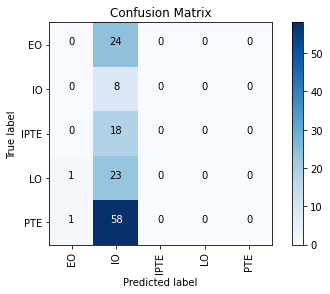

In [36]:
cm_plot_labels = ['EO','IO','IPTE','LO','PTE']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [37]:
print(classification_report(test_batches.classes,np.argmax(predictions,axis=-1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.06      1.00      0.12         8
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        24
           4       0.00      0.00      0.00        59

    accuracy                           0.06       133
   macro avg       0.01      0.20      0.02       133
weighted avg       0.00      0.06      0.01       133



C:\Users\brahi\anaconda3\envs\PFE\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brahi\anaconda3\envs\PFE\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brahi\anaconda3\envs\PFE\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


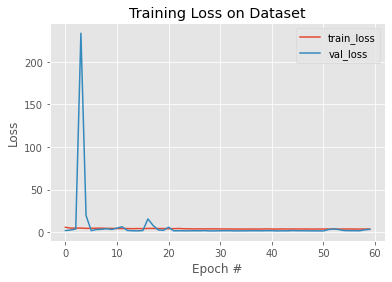

In [38]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

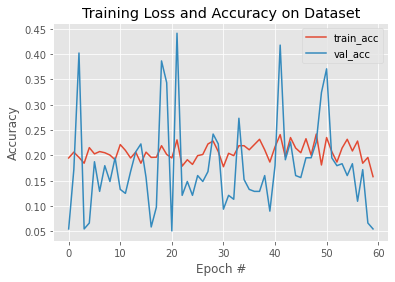

In [39]:
# plot the training accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")